In [ ]:
!pip install scanpy
!pip install ssqueezepy
!pip install pynwb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=f6b77338eb52cf205bd614b9de65dac01d7ea7108eb90bca3d2280a9acb2dcbb
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=b73da2f91a4f9d4a9c3cdc95067fb88f39d4e6f50efee7963bb58b90e080b437
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9b

In [ ]:
%cd ./drive/MyDrive/student_furumichi/

/content/drive/MyDrive/student_furumichi


In [ ]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch import functional as F
from torch.distributions.kl import kl_divergence
from torch.nn import init
from torchvision import transforms
import numpy as np
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from matplotlib import pyplot as plt
import umap
from ssqueezepy import ssq_cwt
torch.cuda.is_available()

True

In [ ]:
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy import integrate
import scipy
import logging
import importlib
import os
import warnings
from PIL import Image
from pynwb import NWBHDF5IO
import statistics
import math
import random

sns.set_style()

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from sklearn import linear_model
ransac = linear_model.RANSACRegressor()

%matplotlib inline

In [ ]:
def get_time_voltage_current_currindex0(nwb):
    df = nwb.sweep_table.to_dataframe()
    voltage = np.zeros((len(df['series'][0][0].data[:]), int((df.shape[0]+1)/2)))
    time = np.arange(len(df['series'][0][0].data[:]))/df['series'][0][0].rate
    voltage[:, 0] = df['series'][0][0].data[:]
    current_initial = df['series'][1][0].data[12000]*df['series'][1][0].conversion
    curr_index_0 = int(-current_initial/20) # index of zero current stimulation
    current = np.linspace(current_initial, (int((df.shape[0]+1)/2)-1)*20+current_initial, \
                         int((df.shape[0]+1)/2))
    for i in range(curr_index_0):   # Find all voltage traces from minimum to 0 current stimulation
        voltage[:, i+1] = df['series'][0::2][(i+1)*2][0].data[:]
    for i in range(curr_index_0, int((df.shape[0]+1)/2)-1):   # Find all voltage traces from 0 to highest current stimulation
        voltage[:, i+1] = df['series'][1::2][i*2+1][0].data[:]
    voltage[:, curr_index_0] = df.loc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
    return time, voltage, current, curr_index_0

In [ ]:
import glob
files = glob.glob("./000008/*")

cell_filename = []
cell_names = []
newfiles = []

for file in files:
    cell_filename.append(file)

for cells in cell_filename:
    pluscells = glob.glob(cells + "/*")
    cell_names.append(pluscells)

for cellname in cell_names:
    newfiles = newfiles + cellname

len(newfiles)

1328

In [ ]:
cell_list = []
for cell in newfiles:
    fixname = cell[45:53] + "_sample_" + cell[61:63] #ifで_を除去
    if fixname[17] == "_":
        fixname = fixname.rstrip("_")

    cell_list.append(fixname)

In [ ]:
# 初期値の設定
pick_voltage = 30
set_timeax = 128
set_freqax = 128

#閾値の設定
i = 790

warnings.filterwarnings("ignore") # It complains about some namespaces, but it should work.

io_ = NWBHDF5IO(newfiles[1131], 'r', load_namespaces=True)
nwb = io_.read()
#ファイルの情報取得
time, voltage, current, curr_index_0 = get_time_voltage_current_currindex0(nwb)

#ファイルのウェーブレット変換
Twxo, Wxo, ssq_freqso, scaleso = ssq_cwt(voltage[:,pick_voltage])

io_ = NWBHDF5IO(newfiles[i], 'r', load_namespaces=True)
nwb = io_.read()
#ファイルの情報取得
time, voltage, current, curr_index_0 = get_time_voltage_current_currindex0(nwb)


<function matplotlib.pyplot.show(close=None, block=None)>

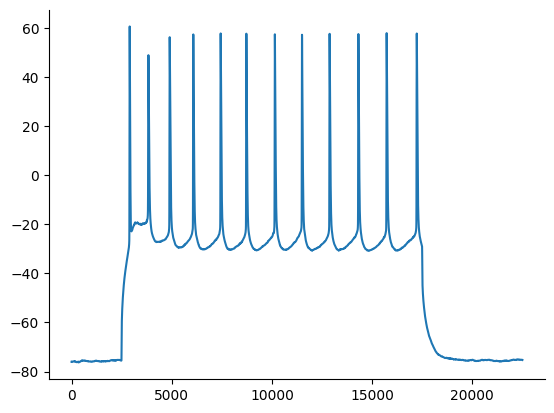

In [ ]:
plt.plot(voltage[:,pick_voltage])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show

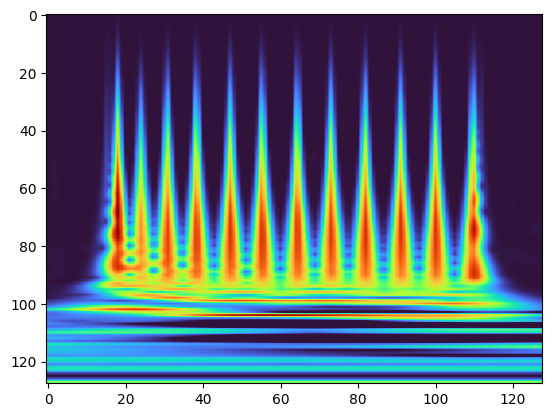

In [ ]:
#ファイルのウェーブレット変換
if voltage.shape[1] >pick_voltage:
    Twxo, Wxo, *_ = ssq_cwt(voltage[:,pick_voltage],ssq_freqs = ssq_freqso,scales = scaleso)
    Image_outcome = np.abs(Wxo)
    image_length = len(Image_outcome[0])
    #resized_outcome = np.array(Image.fromarray(Image_outcome).resize((set_timeax,set_freqax)))
    search_outlier = np.sum(Image_outcome[:,:100],axis=1)
    search_outlier = search_outlier/set_timeax
    #外れ値を削除　基準値設定
    calc_mean = np.mean(search_outlier)
    calc_std = np.std(search_outlier)
    limit_low=calc_mean-calc_std
    limit_high=calc_mean+calc_std

    #外れ値を削除　周波数を抽出
    except_freq = []
    for j in range(len(search_outlier)):
        if (search_outlier[j] > limit_high) or (search_outlier[j] < limit_low) and (j>200):
            except_freq.append(j)
    pick_freq = np.zeros(len(search_outlier))
    np.put(pick_freq,except_freq,1)
    delete_freq = search_outlier * pick_freq
    delete_array = np.tile(delete_freq,(image_length,1)).T
    picked_outcome = Image_outcome - delete_array
    processed_outcome = picked_outcome[75:,:20000]
    resized_outcome = np.array(Image.fromarray(processed_outcome).resize((set_timeax,set_freqax)))
    plt.imshow(resized_outcome, aspect='auto', cmap='turbo', vmin=0)
    #np.save('./data_for_VAE_denoise/' + cell_list[i] + '.npy', resized_outcome)

**Figure2の画像作成**

クラスタ内部のPvalbの部分だけ色付け　Pvalbのbaselineモデル

In [ ]:
import glob
files = glob.glob("./data_for_VAE/*")

test_filename = []

for file in files:
    test_filename.append(file)

len(test_filename)

1325

In [ ]:
from functorch import vmap
from functorch import vjp
from tqdm import tqdm
from PIL import Image

In [ ]:
#遺伝子発現データ作成 low quality除去
adata = sc.read_csv('./m1_patchseq_exon_counts.csv') #データ変更
plus_data = pd.read_table('./m1_patchseq_meta_data.csv',sep='\t',index_col=1) #データ変更
adata = adata.T
adata.obs = plus_data.loc[adata.obs_names]
adata = adata[adata.obs["RNA family"] != "low quality"]
adata.layers['count'] = adata.X
sc.pp.filter_cells(adata,min_counts=100)
sc.pp.filter_genes(adata,min_cells=10)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)

<ipython-input-8-6179c9a3806d>:7: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata.layers['count'] = adata.X


In [ ]:
cells = pd.Series(glob.glob('./data_for_VAE/*.npy')).str.extract("VAE/([^.]+)").iloc[:,0].values
delete_cells = []
for cell in cells:
    if (cell in adata.obs_names) == True:
        delete_cells.append(cell)
adata = adata[delete_cells]
count_mat = torch.Tensor(adata[adata.obs_names,adata.var.highly_variable].layers['count'].toarray())

In [ ]:
cell_id = []
for i in range(len(delete_cells)):
    cell_id.append('./data_for_VAE/' + delete_cells[i] + '.npy')

In [ ]:
set_timeax = 128
set_freqax = 128

#データセットの作成
class VaeDataSet(torch.utils.data.Dataset):
    def __init__(self,x,xcell_id,transform=None,pre_transform=None):
        self.x = x
        self.xcell_id = xcell_id
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return(self.x.shape[0])
    #idx_xにある細胞のanndata、cell_fileに細胞のCWTデータ
    def __getitem__(self,idx):
        idx_x = self.x[idx]
        idx_xcell_id = np.load(self.xcell_id[idx])
        idx_xcell_id = np.array(Image.fromarray(idx_xcell_id).resize((set_timeax,set_freqax)))
        #idx_xcell_id = self.normalize(idx_xcell_id)
        #idx_xcell_id = torch.from_numpy(idx_xcell_id.astype(np.float32)).clone()
        idx_xcell_id = self.transform(idx_xcell_id)
        idx_xcell_name = self.xcell_id[idx]
        return(idx_x,idx_xcell_id,idx_xcell_name)

    def normalize(self,img):
        return (img-img.min())/(img.max()-img.min())

# idx を　cell_idで代用できるか？
dataset = VaeDataSet(count_mat,cell_id)

In [ ]:
test_ratio = 0.05
val_ratio = 0.1

total_size = len(dataset)
test_size = int(total_size * test_ratio)
val_size = int(total_size * val_ratio)
train_size = total_size - test_size - val_size

train_dataset,val_dataset,test_dataset = torch.utils.data.dataset.random_split(dataset,[train_size,val_size,test_size],generator=torch.Generator().manual_seed(42))

features1 = []
features2 = []
features3 = [] #
for i in range(len(val_dataset)):
    val_x = val_dataset[i][0]
    features1.append(val_x)
    val_xcell_id = val_dataset[i][1]
    features2.append(val_xcell_id)
    val_xcell_name = val_dataset[i][2] #
    features3.append(val_xcell_name) #
val_x = torch.stack(features1, dim = 0)
val_xcell_id = torch.stack(features2, dim = 0)

In [ ]:
#評価用のデータセット
valid_list = []
for val_cell in features3:
    valname = val_cell[15:23] + "_sample_" + val_cell[31:33] #ifで_を除去
    if valname[17] == ".":
        valname = valname.rstrip(".")

    valid_list.append(valname)

In [ ]:
#model VAE t-feature

class LinearReLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearReLU, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim, elementwise_affine=False),
            nn.ReLU(True))

    def forward(self, x):
        h = self.f(x)
        return(h)


class SeqNN(nn.Module):
    def __init__(self, num_steps, dim):
        super(SeqNN, self).__init__()
        modules = [
            LinearReLU(dim, dim)
            for _ in range(num_steps)
        ]
        self.f = nn.Sequential(*modules)

    def forward(self, pre_h):
        post_h = self.f(pre_h)
        return(post_h)


class TEncoder(nn.Module):
    def __init__(self, num_h_layers, x_dim, h_dim, z_dim): #2,2000,50,10
        super(TEncoder, self).__init__()
        self.x2z = LinearReLU(x_dim, h_dim) #2000,50
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim) #1,50
        self.h2mu = nn.Linear(h_dim, z_dim) #50,10
        self.h2logvar = nn.Linear(h_dim, z_dim) #50,10

    def forward(self, x):
        pre_h = self.x2z(x)
        post_h = self.seq_nn(pre_h)
        mu = self.h2mu(post_h)
        logvar = self.h2logvar(post_h)
        return(mu, logvar)


class TDecoder(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim, x_dim):
        super(TDecoder, self).__init__()
        self.z2x = LinearReLU(z_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim)
        self.h2ld = nn.Linear(h_dim, x_dim)
        self.softplus = nn.Softplus()

    def forward(self, z):
        pre_h = self.z2x(z)
        post_h = self.seq_nn(pre_h)
        ld = self.h2ld(post_h)
        correct_ld = self.softplus(ld)
        return(correct_ld)

class tscVAE(nn.Module):
    def __init__(
            self,
            x_dim, xz_dim, #i_dimになってた
            enc_z_h_dim, dec_z_h_dim,
            num_enc_z_layers,
            num_dec_z_layers, **kwargs):
        super(tscVAE, self).__init__()
        self.enc_z = TEncoder(num_enc_z_layers, x_dim, enc_z_h_dim, xz_dim)
        self.dec_z2x = TDecoder(num_enc_z_layers, xz_dim, dec_z_h_dim, x_dim)
        self.softplus = nn.Softplus()
        self.logtheta_x =  Parameter(torch.Tensor(x_dim))
        self.reset_parameters()

    def reset_parameters(self):
        init.normal_(self.logtheta_x)

    def forward(self, x):
        # encode z
        qz_mu, qz_logvar = self.enc_z(x)
        qz = dist.Normal(qz_mu, self.softplus(qz_logvar))
        z = qz.rsample()
        # decode z
        xld = self.dec_z2x(z)
        xld = xld + 1e-10
        return(z, qz, xld)

x_dim = count_mat.size()[1] #2000
xz_dim, enc_z_h_dim, dec_z_h_dim, num_enc_z_layers, num_dec_z_layers = 10, 50, 50, 2, 2

In [ ]:
#model  Res_VAE e-feature

class EEncoder(nn.Module):
    def __init__(self, num_h_layers, x_dim, h_dim, z_dim): #2,2000,50,10
        super(EEncoder, self).__init__()
        self.x2h = LinearReLU(x_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim) #1,50
        self.h2mu = nn.Linear(h_dim, z_dim) #50,10
        self.h2logvar = nn.Linear(h_dim, z_dim) #50,10

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size,128*128)
        pre_h = self.x2h(x)
        post_h = self.seq_nn(pre_h)
        mu = self.h2mu(post_h)
        logvar = self.h2logvar(post_h)
        return(mu, logvar)

class EDecoder(nn.Module):
    def __init__(self, num_h_layers, z_dim, h_dim, x_dim):
        super(EDecoder, self).__init__()
        self.z2h = LinearReLU(z_dim, h_dim)
        self.seq_nn = SeqNN(num_h_layers - 1, h_dim)
        self.h2x = nn.Sequential(
            nn.Linear(h_dim,2048),
            nn.ReLU(),
            nn.Linear(2048,x_dim)
        )
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, z):
        batch_size = z.size(0)
        pre_h = self.z2h(z)
        post_h = self.seq_nn(pre_h)
        post_h = self.h2x(post_h)
        #e_feature = self.sigmoid(post_h)
        e_feature = self.softplus(post_h)
        return(e_feature)


class escVAE(nn.Module):
    def __init__(
            self,
            i_dim, xz_dim,
            enc_z_h_dim, dec_z_h_dim,
            num_enc_z_layers,
            num_dec_z_layers, **kwargs):
        super(escVAE, self).__init__()
        self.enc_z = EEncoder(num_enc_z_layers, i_dim, enc_z_h_dim, xz_dim)
        self.dec_z2x = EDecoder(num_enc_z_layers, xz_dim, dec_z_h_dim, i_dim)
        self.softplus = nn.Softplus()
        self.logtheta_x =  Parameter(torch.Tensor(i_dim))
        self.reset_parameters()

    def reset_parameters(self):
        init.normal_(self.logtheta_x)

    def forward(self, x):
        # encode z
        qz_mu, qz_logvar = self.enc_z(x)
        qz = dist.Normal(qz_mu, self.softplus(qz_logvar))
        z = qz.rsample()
        # decode z
        ld_img = self.dec_z2x(z)
        return(z, qz, ld_img)

i_dim = np.load(cell_id[0]).reshape(-1).shape[0]
xz_dim, enc_z_h_dim, dec_z_h_dim, num_enc_z_layers, num_dec_z_layers = 10, 500, 500, 2, 2
e_model = escVAE(
    i_dim, xz_dim,
    enc_z_h_dim, dec_z_h_dim,
    num_enc_z_layers, num_dec_z_layers)

In [ ]:
#t_modelのパラメータをload
t_model = tscVAE(
    x_dim, xz_dim,
    enc_z_h_dim, dec_z_h_dim,
    num_enc_z_layers, num_dec_z_layers)
t_model.load_state_dict(torch.load('./tmodel_tVAE.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
#e_modelのパラメータをload
e_model = escVAE(
    i_dim, xz_dim,
    enc_z_h_dim, dec_z_h_dim,
    num_enc_z_layers, num_dec_z_layers)
e_model.load_state_dict(torch.load('./emodel_eVAE.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
#潜在変数のデータセットを作成する
#t-featureのz,e-featureのzをペアにした潜在変数データセットを作成
class zDataSet(torch.utils.data.Dataset):
    def __init__(self,x,xcell_id,transform=None,pre_transform=None):
        self.x = x
        self.xcell_id = xcell_id
        self.transform = transforms.Compose([transforms.ToTensor()])
    def __len__(self):
        return(self.x.shape[0])
    #idx_xにある細胞のanndata、cell_fileに細胞のCWTデータ
    def __getitem__(self,idx):
        #t_zを設定
        idx_x = self.x[idx]
        qz_mu, qz_logvar = t_model.enc_z(idx_x)
        qz_logvar = t_model.softplus(qz_logvar)
        qz = dist.Normal(qz_mu, qz_logvar)
        t_z = qz.rsample()
        #e_zを設定
        idx_xcell_id = np.load(self.xcell_id[idx])
        idx_xcell_id = np.array(Image.fromarray(idx_xcell_id).resize((set_timeax,set_freqax)))
        idx_xcell_id = self.transform(idx_xcell_id)
        qz_mu, qz_logvar = e_model.enc_z(idx_xcell_id)
        qz_logvar = e_model.softplus(qz_logvar)
        qz = dist.Normal(qz_mu, qz_logvar)
        e_z = qz.rsample()
        e_z = e_z.squeeze()
        return(t_z,e_z)

    def normalize(self,img):
        return (img-img.min())/(img.max()-img.min())

# idx を　cell_idで代用できるか？
zdataset = zDataSet(count_mat,cell_id)

In [ ]:
#linkZのためのデータセットをload
train_zdataset,val_zdataset,test_zdataset = torch.utils.data.dataset.random_split(zdataset,[train_size,val_size,test_size],generator=torch.Generator().manual_seed(42))

tz_features = []
ez_features = []
for i in range(len(val_zdataset)):
    plus_tz = val_zdataset[i][0]
    tz_features.append(plus_tz)
    plus_ez = val_zdataset[i][1]
    ez_features.append(plus_ez)

val_tz = torch.stack(tz_features)
val_ez = torch.stack(ez_features)

In [ ]:
ez_train_features = []
for i in tqdm(range(len(train_zdataset))):
    train_ez = train_zdataset[i][1]
    ez_train_features.append(train_ez)
val_ez_train = torch.stack(ez_train_features)

100%|██████████| 1045/1045 [00:04<00:00, 211.04it/s]


In [ ]:
class Distributor(nn.Module):
    def __init__(self, latent_dim: int, h_dim: int = 64) -> None:
        super().__init__()
        self.zk2w = nn.Linear(latent_dim, h_dim)
        self.zl2wb = nn.Linear(latent_dim, h_dim+1)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, t_z, e_z):
        w_i = self.zk2w(e_z)
        wb_z = self.zl2wb(t_z)
        w_z, b_z = wb_z[..., :-1], wb_z[..., -1]
        lp = -self.logsoftmax(w_i @ w_z.T + b_z)
        return lp

    def inference(self, t_z, val_ez_train=val_ez_train, val_ez = val_ez):
        w_i = self.zk2w(val_ez_train)
        wb_z = self.zl2wb(t_z)
        w_z, b_z = wb_z[..., :-1], wb_z[..., -1]
        calc_z = w_i @ w_z.T + b_z
        calc_z = calc_z * 3
        best_z = self.softmax(calc_z)
        best_ez = val_ez_train.T @ best_z
        return  best_ez

In [ ]:
#linkz_modelのパラメータをload
linkz_model = Distributor(latent_dim=10)
linkz_model.load_state_dict(torch.load('./linkzmodel_bindVAE.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
linkz_model.to("cpu")
t_model.to("cpu")
e_model.to("cpu")

escVAE(
  (enc_z): EEncoder(
    (x2h): LinearReLU(
      (f): Sequential(
        (0): Linear(in_features=16384, out_features=500, bias=True)
        (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
        (2): ReLU(inplace=True)
      )
    )
    (seq_nn): SeqNN(
      (f): Sequential(
        (0): LinearReLU(
          (f): Sequential(
            (0): Linear(in_features=500, out_features=500, bias=True)
            (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
            (2): ReLU(inplace=True)
          )
        )
      )
    )
    (h2mu): Linear(in_features=500, out_features=10, bias=True)
    (h2logvar): Linear(in_features=500, out_features=10, bias=True)
  )
  (dec_z2x): EDecoder(
    (z2h): LinearReLU(
      (f): Sequential(
        (0): Linear(in_features=10, out_features=500, bias=True)
        (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
        (2): ReLU(inplace=True)
      )
    )
    (seq_nn): SeqNN(
      (f): Sequential(
     

In [ ]:
#学習させたモデルをmerge
def MergeVAE(t):
    qz_mu, qz_logvar = t_model.enc_z(t)
    qz_logvar = t_model.softplus(qz_logvar)
    qz = dist.Normal(qz_mu, qz_logvar)
    z_t = qz.rsample()
    z_e = linkz_model.inference(z_t)
    #e_img = z_e
    e_img = e_model.dec_z2x(z_e)
    return(e_img)

Pvalbのリストを作る

In [ ]:
valid_data = adata[valid_list]

In [ ]:
#Validation_datasetの各細胞タイプ
Vip_validlist = []
Lamp5_validlist = []
Pvalb_validlist = []
Sst_validlist = []
ET_validlist = []
IT_validlist = []
CT_validlist = []

for i in range(len(valid_data.obs)):
    if valid_data.obs["RNA family"][i] == "Vip":
        Vip_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "Lamp5":
        Lamp5_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "Pvalb":
        Pvalb_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "Sst":
        Sst_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "ET":
        ET_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "IT":
        IT_validlist.append(valid_data.obs_names[i])
    if valid_data.obs["RNA family"][i] == "CT":
        CT_validlist.append(valid_data.obs_names[i])
    else:
        continue

潜在空間をUMAPで表示

In [ ]:
image_shape = np.load(cell_id[0]).shape
plus_data = pd.read_table('./m1_patchseq_meta_data.csv',sep='\t',index_col=1) #データ変更
adata.obs = plus_data.loc[adata.obs_names]

In [ ]:
features4 = []
features5 = []
features6 = []

for i in range(len(dataset)):
    test_x = dataset[i][0]
    features4.append(test_x)
    test_xcell_id = dataset[i][1]
    test_xcell_id = test_xcell_id.flatten()
    #print(test_xcell_id)
    features5.append(test_xcell_id)
    test_xcell_name = dataset[i][2] #
    features6.append(test_xcell_name) #

test_x = torch.stack(features4, dim = 0)
test_xcell_id = torch.stack(features5, dim = 0)

In [ ]:
#評価用のデータセット
test_list = []
for test_cell in features6:
    testname = test_cell[15:23] + "_sample_" + test_cell[31:33] #ifで_を除去
    if testname[17] == ".":
        testname = testname.rstrip(".")

    test_list.append(testname)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#各細胞タイプについてindexを作成
Vip_index = []
Lamp5_index = []
Pvalb_index = []
Sst_index = []
ET_index = []
IT_index = []
CT_index = []

for i in range(len(test_list)):
    if adata[test_list[i]].obs["RNA family"].item() == "Vip":
        Vip_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "Lamp5":
        Lamp5_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "Pvalb":
        Pvalb_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "Sst":
        Sst_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "ET":
        ET_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "IT":
        IT_index.append(i)
    if adata[test_list[i]].obs["RNA family"].item() == "CT":
        CT_index.append(i)
    else:
        continue

In [ ]:
#ユークリッド距離を使用して単一クラスターの medoid を計算する
def GetMedoid(vX):
  vMean = np.mean(vX, axis=0)                          # compute centroid
  return vX[np.argmin([sum((x - vMean)**2) for x in vX])]   # pick a point closest to centroid

#vCenroid = np.mean(pick_pvalb, axis=0) #クラスターの平均を出す

In [ ]:
#inference
test_x = test_x.to(device)
t_model.to(device)

with torch.no_grad():
    t_model.eval()
    z, qz, xld = t_model(test_x)

reducer = umap.UMAP(n_neighbors=30,min_dist=0.1)
embedding = reducer.fit_transform(z.cpu().detach().numpy())

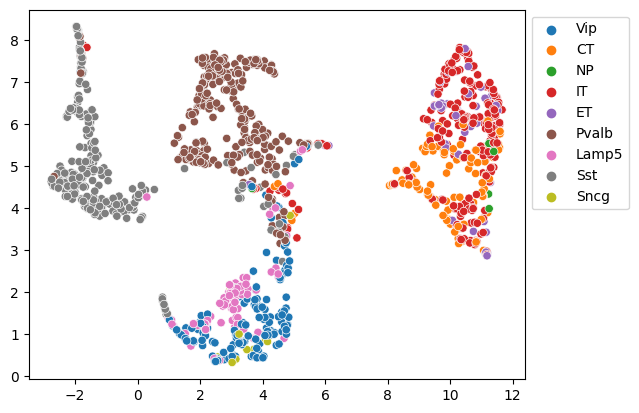

In [ ]:
sns.scatterplot(x = embedding[:,0],y = embedding[:,1],hue=adata.obs['RNA family'])
plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

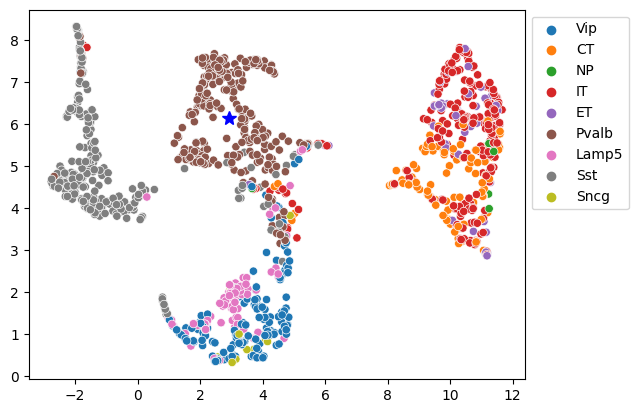

In [ ]:
#各細胞タイプのembeddingされた値を抽出
emb_Vip = embedding[Vip_index]
emb_Lamp5 = embedding[Lamp5_index]
emb_Pvalb = embedding[Pvalb_index]
emb_Sst = embedding[Sst_index]
emb_ET = embedding[ET_index]
emb_IT = embedding[IT_index]
emb_CT = embedding[CT_index]

Vip_Medoid = GetMedoid(emb_Vip)
Lamp5_Medoid = GetMedoid(emb_Lamp5)
Pvalb_Medoid = GetMedoid(emb_Pvalb)
Sst_Medoid = GetMedoid(emb_Sst)
ET_Medoid = GetMedoid(emb_ET)
IT_Medoid = GetMedoid(emb_IT)
CT_Medoid = GetMedoid(emb_CT)

vCenroid = np.mean(emb_Pvalb, axis=0)

#embedded celltypes
sns.scatterplot(x = embedding[:,0],y = embedding[:,1],hue=adata.obs['RNA family'])
#plt.plot(vCenroid[0], vCenroid[1], 'b*', ms=13);   # plot centroid as red circle
plt.plot(vCenroid[0], vCenroid[1], 'b*', ms=10);
#plt.plot(Pvalb_Medoid[0], Pvalb_Medoid[1], 'b*', ms=10);
#plt.scatter(Vip_Medoid[0], Vip_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(Lamp5_Medoid[0], Lamp5_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(Pvalb_Medoid[0], Pvalb_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(Sst_Medoid[0], Sst_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(ET_Medoid[0], ET_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(IT_Medoid[0], IT_Medoid[1], s=25, facecolor="None", edgecolor="black");
#plt.scatter(CT_Medoid[0], CT_Medoid[1], s=25, facecolor="None", edgecolor="black");

plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

In [ ]:
len(emb_Vip)

153

In [ ]:
#e_modelでも同様に作成
test_xcell_id = test_xcell_id.to(device)
e_model.to(device)

with torch.no_grad():
    e_model.eval()
    z, qz, xld = e_model(test_xcell_id)

reducer = umap.UMAP(n_neighbors=30,min_dist=0.1)
embedding = reducer.fit_transform(z.cpu().detach().numpy())

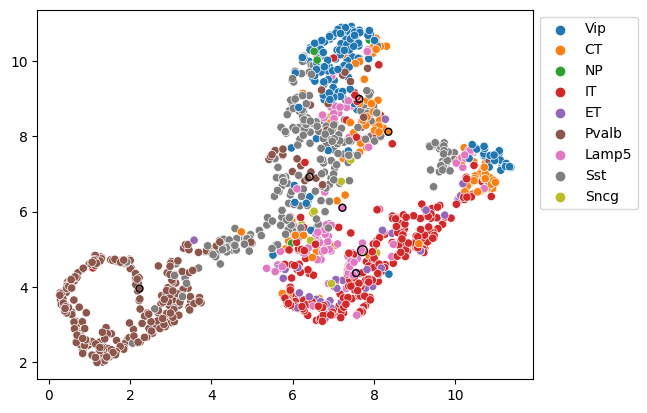

In [ ]:
#各細胞タイプのembeddingされた値を抽出
emb_Vip = embedding[Vip_index]
emb_Lamp5 = embedding[Lamp5_index]
emb_Pvalb = embedding[Pvalb_index]
emb_Sst = embedding[Sst_index]
emb_ET = embedding[ET_index]
emb_IT = embedding[IT_index]
emb_CT = embedding[CT_index]

Vip_Medoid = GetMedoid(emb_Vip)
Lamp5_Medoid = GetMedoid(emb_Lamp5)
Pvalb_Medoid = GetMedoid(emb_Pvalb)
Sst_Medoid = GetMedoid(emb_Sst)
ET_Medoid = GetMedoid(emb_ET)
IT_Medoid = GetMedoid(emb_IT)
CT_Medoid = GetMedoid(emb_CT)

#embedded celltypes
sns.scatterplot(x = embedding[:,0],y = embedding[:,1],hue=adata.obs['RNA family'])
#plt.plot(vCenroid[0], vCenroid[1], 'b*', ms=13);   # plot centroid as red circle
plt.scatter(Vip_Medoid[0], Vip_Medoid[1], s=25, facecolor="None", edgecolor="black");
plt.scatter(Lamp5_Medoid[0], Lamp5_Medoid[1], s=25, facecolor="None", edgecolor="black");
plt.scatter(Pvalb_Medoid[0], Pvalb_Medoid[1], s=25, facecolor="None", edgecolor="black");
plt.scatter(Sst_Medoid[0], Sst_Medoid[1], s=25, facecolor="None", edgecolor="black");
plt.scatter(ET_Medoid[0], ET_Medoid[1], s=25, facecolor="None", edgecolor="black");
plt.scatter(IT_Medoid[0], IT_Medoid[1], s=50, facecolor="None", edgecolor="black");
plt.scatter(CT_Medoid[0], CT_Medoid[1], s=25, facecolor="None", edgecolor="black");

plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

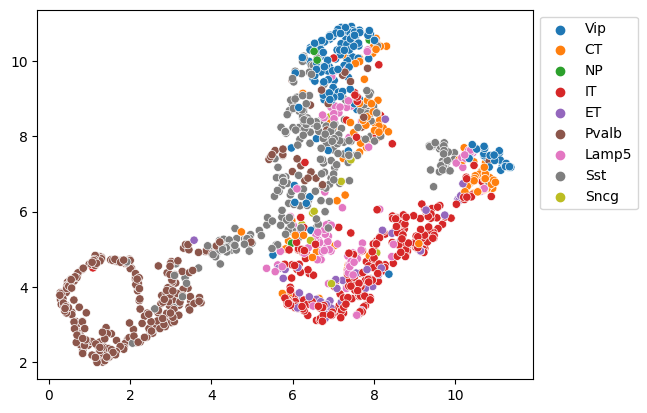

In [ ]:
sns.scatterplot(x = embedding[:,0],y = embedding[:,1],hue=adata.obs['RNA family'])
plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

In [ ]:
embedding = np.load('./eVAE_embedding.npy')

In [ ]:
Pvalb_Medoid

array([2.2274525, 3.955485 ], dtype=float32)

baselineモデルを作る

In [ ]:
#評価用のデータセット
train_cell = []
for i in range(len(train_dataset)):
    train_xcell_name = train_dataset[i][2]
    train_cell.append(train_xcell_name)
train_list = []
for train_cell in train_cell:
    trainname = train_cell[15:23] + "_sample_" + train_cell[31:33] #ifで_を除去
    if trainname[17] == ".":
        trainname = trainname.rstrip(".")

    train_list.append(trainname)

train_data = adata[train_list]

In [ ]:
#Validation_datasetの各細胞タイプ
Pvalb_trainlist = []

for i in range(len(train_data.obs)):
    if train_data.obs["RNA family"][i] == "Pvalb":
        Pvalb_trainlist.append(train_data.obs_names[i])
    else:
        continue

In [ ]:
#baselineモデル
rightimage_sum = torch.zeros(128,128)

for trainsample in Pvalb_trainlist:
    train_sample = trainsample
    #正解画像の読み込み
    read_image = np.load("./data_for_VAE/" + train_sample +  ".npy")
    right_image = read_image.reshape(np.load("./data_for_VAE/20190703_sample_14.npy").shape)
    #print(right_image.max())
    #right_image = np.ravel(right_image)
    rightimage_sum = rightimage_sum + right_image

rightimage_avr = rightimage_sum / len(Pvalb_trainlist)

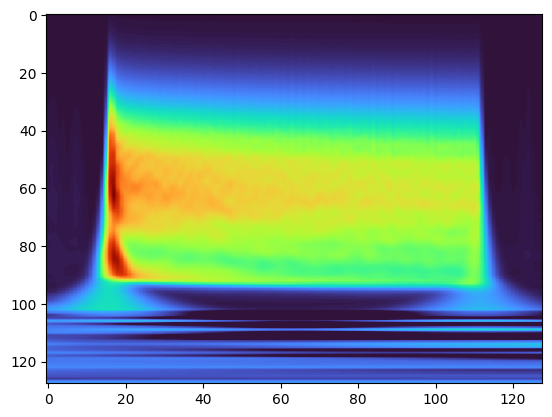

In [ ]:
rightimage_avr = rightimage_avr.to('cpu').detach().numpy().copy()
plt.imshow(rightimage_avr, aspect='auto', cmap='turbo', vmin=0)

In [ ]:
genetype_sum = torch.zeros(count_mat.size()[1])
counts = 0
for i in range(len(adata.obs)):
    if adata.obs["RNA family"][i] == "Pvalb":
        obsname = adata.obs_names[i]
        cdata = adata[obsname]
        count_mat1 = torch.Tensor(adata[cdata.obs_names,cdata.var.highly_variable].layers['count'].toarray())
        count_mat1 = count_mat1.squeeze()
        genetype_sum = genetype_sum + count_mat1
        counts = counts + 1

genetype_avr = torch.div(genetype_sum,counts)
#genetype_avr = torch.unsqueeze(genetype_avr, dim=0)

In [ ]:
t_model.to("cpu")
e_model.to("cpu")

escVAE(
  (enc_z): EEncoder(
    (x2h): LinearReLU(
      (f): Sequential(
        (0): Linear(in_features=16384, out_features=500, bias=True)
        (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
        (2): ReLU(inplace=True)
      )
    )
    (seq_nn): SeqNN(
      (f): Sequential(
        (0): LinearReLU(
          (f): Sequential(
            (0): Linear(in_features=500, out_features=500, bias=True)
            (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
            (2): ReLU(inplace=True)
          )
        )
      )
    )
    (h2mu): Linear(in_features=500, out_features=10, bias=True)
    (h2logvar): Linear(in_features=500, out_features=10, bias=True)
  )
  (dec_z2x): EDecoder(
    (z2h): LinearReLU(
      (f): Sequential(
        (0): Linear(in_features=10, out_features=500, bias=True)
        (1): LayerNorm((500,), eps=1e-05, elementwise_affine=False)
        (2): ReLU(inplace=True)
      )
    )
    (seq_nn): SeqNN(
      (f): Sequential(
     

<ipython-input-21-d3a6c7f39fe4>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  calc_z = w_i @ w_z.T + b_z


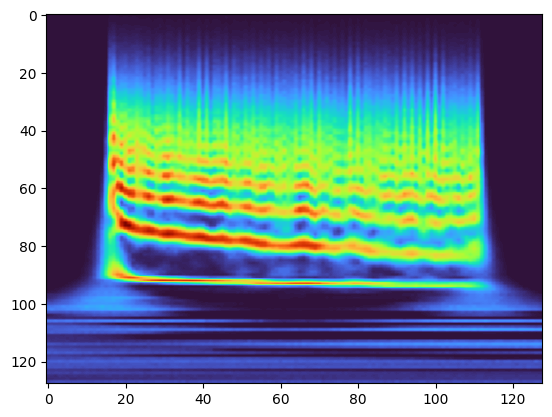

In [ ]:
e_img = MergeVAE(genetype_avr)
e_img1 = e_img.reshape(np.load("./data_for_VAE/20191001_sample_4.npy").shape)
predicted_image = e_img1.to('cpu').detach().numpy().copy()
plt.imshow(predicted_image, aspect='auto', cmap='turbo', vmin=0)

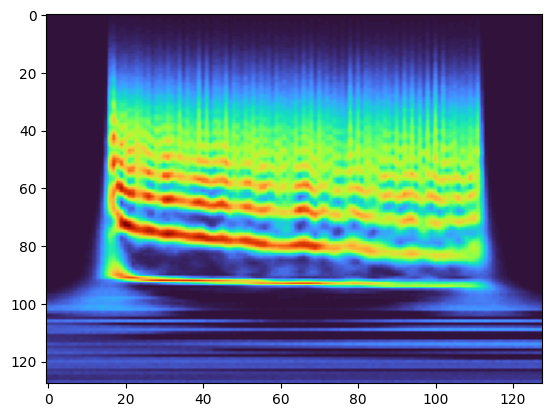

In [ ]:
plt.imshow(predicted_image, aspect='auto', cmap='turbo', vmin=0)

各細胞タイプのmedoidについて、モデルでの再構成画像を作る

In [ ]:
#ユークリッド距離を使用して単一クラスターの medoid を計算する
def GetMedoid(vX):
  vMean = np.mean(vX, axis=0)
  min_number = np.argmin([sum((x - vMean)**2) for x in vX])                           # compute centroid
  return vX[min_number], min_number   # pick a point closest to centroid

#vCenroid = np.mean(pick_pvalb, axis=0) #クラスターの平均を出す

In [ ]:
Pvalb_Medoid, Pvalb_number= GetMedoid(emb_Pvalb)

In [ ]:
Pvalb_Mednum = Pvalb_index[Pvalb_number]

In [ ]:
right_image = test_xcell_id[Pvalb_Mednum]

In [ ]:
right_image = read_image.reshape(np.load("./data_for_VAE_checked/20190703_sample_14.npy").shape)
right_image = torch.from_numpy(right_image.astype(np.float32)).clone()

In [ ]:
right_image = torch.from_numpy(right_image.astype(np.float32)).clone()

In [ ]:
rightimage_avr = rightimage_avr.to('cpu').detach().numpy().copy()

In [ ]:
predicted_image = MergeVAE(genetype_avr)
predicted_image = predicted_image.reshape(np.load("./data_for_VAE/20191001_sample_4.npy").shape)

In [ ]:
LPIPS_Pvalb_VAE = loss_fn_alex(right_image, predicted_image)

In [ ]:
LPIPS_Pvalb_baseline = loss_fn_alex(right_image, rightimage_avr)

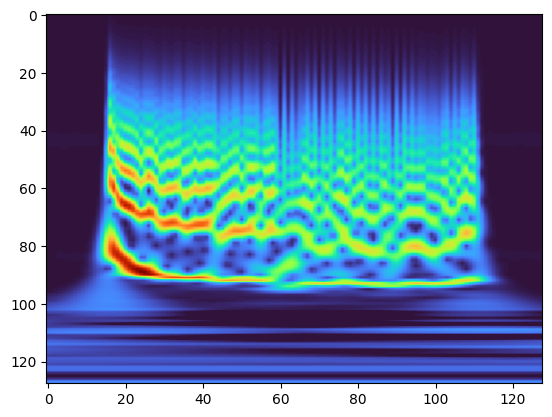

In [ ]:
right_image = right_image.to('cpu').detach().numpy().copy()
plt.imshow(right_image, aspect='auto', cmap='turbo', vmin=0)

In [ ]:
LPIPS_Pvalb_VAE.item()

0.16630512475967407

In [ ]:
LPIPS_Pvalb_baseline.item()

0.3554537296295166

In [ ]:
#細胞タイプ部分を変えれば汎用化できる

from copy import Error
#VAEモデルとbaselineモデルの性能を比較する(argmax,validation_data only)
CT_VAE = []
CT_baseline = []

for validsample in CT_validlist:
    valid_sample = validsample
    #正解画像の読み込み
    read_image = np.load("./data_for_VAE_checked/" + valid_sample +  ".npy")
    right_image = read_image.reshape(np.load("./data_for_VAE_checked/20190703_sample_14.npy").shape)
    right_image = torch.from_numpy(right_image.astype(np.float32)).clone()
    right_sum = torch.sum(right_image)

    #予測画像の読み込み
    testdata = adata[valid_sample]
    testcount_mat = torch.Tensor(testdata[testdata.obs_names,testdata.var.highly_variable].layers['count'].toarray())
    testcount_mat = torch.ravel(testcount_mat)
    test_image = MergeVAE(testcount_mat)
    predicted_image = test_image.reshape(np.load("./data_for_VAE_checked/20190703_sample_14.npy").shape)
    predict_sum = torch.sum(predicted_image)
    #predicted_image = (predicted_image)*(right_sum/predict_sum)

    #VAEのLPIPS
    LPIPS_vae = loss_fn_alex(right_image,predicted_image)
    CT_VAE.append(LPIPS_vae)
    LPIPS_baseline = loss_fn_alex(right_image,rightimage_avr)
    CT_baseline.append(LPIPS_baseline)

CT_list = []
for CT_num in range(len(CT_VAE)):
    CT_list.append(CT_VAE[CT_num].item())
CT_baseline_list = []
for baseline_num in range(len(CT_baseline)):
    CT_baseline_list.append(CT_baseline[baseline_num].item())

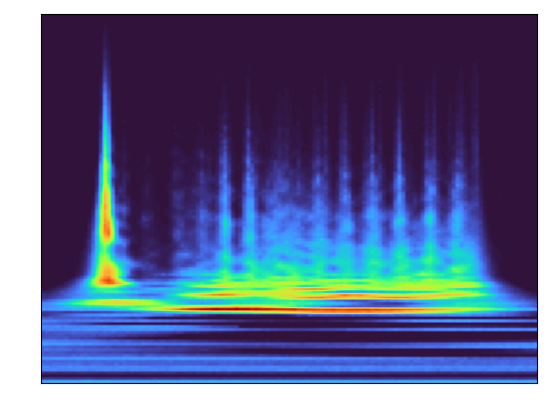

In [ ]:
#細胞タイプのmedoidとなる細胞のindexを取得
CT_Medoid, CT_number= GetMedoid(emb_CT)
CT_Mednum = CT_index[CT_number]

#画像の再構成
med_img = MergeVAE(test_x[CT_Mednum].to("cpu"))
rmed_img = med_img.reshape(np.load("./data_for_VAE/20191001_sample_4.npy").shape)
pmed_image = rmed_img.to('cpu').detach().numpy().copy()
plt.imshow(pmed_image, aspect='auto', cmap='turbo', vmin=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)

LPIPSを計算する

In [ ]:
!pip install lpips

In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
#細胞タイプ部分を変えれば汎用化できる

from copy import Error
#VAEモデルとbaselineモデルの性能を比較する(argmax,validation_data only)
CT_VAE = []
CT_baseline = []

for validsample in CT_validlist:
    valid_sample = validsample
    #正解画像の読み込み
    read_image = np.load("./data_for_VAE_checked/" + valid_sample +  ".npy")
    right_image = read_image.reshape(np.load("./data_for_VAE_checked/20190703_sample_14.npy").shape)
    right_image = torch.from_numpy(right_image.astype(np.float32)).clone()
    right_sum = torch.sum(right_image)

    #予測画像の読み込み
    testdata = adata[valid_sample]
    testcount_mat = torch.Tensor(testdata[testdata.obs_names,testdata.var.highly_variable].layers['count'].toarray())
    testcount_mat = torch.ravel(testcount_mat)
    test_image = MergeVAE(testcount_mat)
    predicted_image = test_image.reshape(np.load("./data_for_VAE_checked/20190703_sample_14.npy").shape)
    predict_sum = torch.sum(predicted_image)
    #predicted_image = (predicted_image)*(right_sum/predict_sum)

    #VAEのLPIPS
    LPIPS_vae = loss_fn_alex(right_image,predicted_image)
    CT_VAE.append(LPIPS_vae)
    LPIPS_baseline = loss_fn_alex(right_image,rightimage_avr)
    CT_baseline.append(LPIPS_baseline)

CT_list = []
for CT_num in range(len(CT_VAE)):
    CT_list.append(CT_VAE[CT_num].item())
CT_baseline_list = []
for baseline_num in range(len(CT_baseline)):
    CT_baseline_list.append(CT_baseline[baseline_num].item())

In [ ]:
dfVAE_Vip = pd.DataFrame({'Vip':Vip_list})
dfVAE_Lamp5 = pd.DataFrame({'Lamp5':Lamp5_list})
new_df = pd.concat([dfVAE_Vip, dfVAE_Lamp5],axis=1)

In [ ]:
dfVAE_CT = pd.DataFrame({'CT':CT_list})

In [ ]:
new_df = pd.concat([new_df, dfVAE_CT],axis=1)

In [ ]:
dfbase_Vip = pd.DataFrame({'Vip':Vip_baseline_list})
dfbase_Lamp5 = pd.DataFrame({'Lamp5':Lamp5_baseline_list})
new_df1 = pd.concat([dfbase_Vip, dfbase_Lamp5],axis=1)

In [ ]:
dfbase_CT = pd.DataFrame({'CT':CT_baseline_list})
new_df1 = pd.concat([new_df1, dfbase_CT],axis=1)

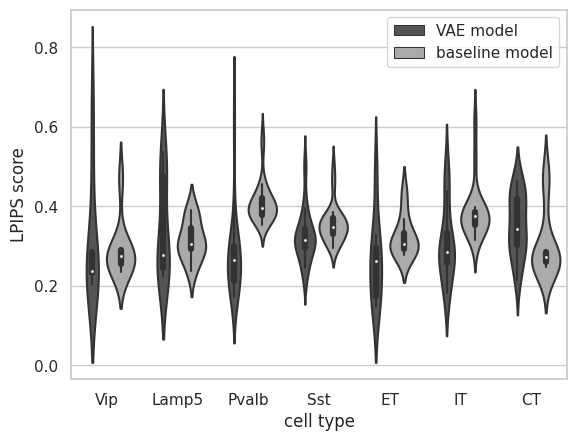

In [ ]:
plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')

#np.random.seed(2018)

dfVAE_melt = pd.melt(new_df)
dfVAE_melt['species'] = 'VAE model'
dfbase_melt = pd.melt(new_df1)
dfbase_melt['species'] = 'baseline model'

df = pd.concat([dfVAE_melt, dfbase_melt], axis=0)

labels = ['Vip', 'Lamp5', 'Pvalb', 'Sst', 'ET', 'IT', 'CT']
#labels = ['Vip']
# step3 グラフフレームの作成
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.violinplot(x='variable', y='value', data=df, hue='species', dodge=True,
              jitter=True, color='black', palette='gray', ax=ax)
# step4 バイオリン図の描画
#ax.boxplot([x1,x2,x3,x4,x5,x6,x7,x8],showmeans=True)

#ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax.set_xticks(np.arange(0, len(labels)), labels=labels)
ax.set_xlabel('cell type')
ax.set_ylabel('LPIPS score')
#ax.set_title('corr')

ax.legend()
plt.show()

In [ ]:
new_df1.to_csv('./to_csv_baseline_LPIPS.csv')

In [ ]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(new_df["Pvalb"].dropna(how='any'),new_df1["Pvalb"].dropna(how='any'))

In [ ]:
#p値の計算
for celltype in labels:
    t_stat, p_val = ttest_ind(new_df[celltype].dropna(how='any'),new_df1[celltype].dropna(how='any'))
    print(p_val)

0.7436371331877423
0.557298270506607
2.1073694611927517e-06
0.029257167075514245
0.17941106051027214
0.006586874578672399
0.08526591920429107


In [ ]:
#VAEのLPIPSの中央値
for celltype in labels:
    print(statistics.median(new_df[celltype].dropna(how='any')))

0.23688514530658722
0.2768692970275879
0.2658214271068573
0.31589823961257935
0.2623571753501892
0.28447969257831573
0.3436626195907593


In [ ]:
#VAEのLPIPSの中央値
for celltype in labels:
    print(statistics.median(new_df1[celltype].dropna(how='any')))

0.2737959027290344
0.3051053583621979
0.39676839113235474
0.34891270101070404
0.3056677281856537
0.3747784495353699
0.2724044919013977


In [ ]:
p_val

2.1073694611927517e-06

e-featuresをPCA表示してみる

In [ ]:
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

In [ ]:
test_x[1]

tensor([   0.,   17.,    0.,  ...,    0.,  754., 1882.], device='cuda:0')

In [ ]:
128*128

16384

In [ ]:
X = torch.zeros(1,16384)

In [ ]:
len(test_x)

1228

In [ ]:
efeature_list = []
for i in tqdm(range(len(test_x))):
    ld_img = MergeVAE(test_x[i].to("cpu"))
    efeature_list.append(ld_img)


100%|██████████| 1228/1228 [00:25<00:00, 48.56it/s]


In [ ]:
torch.stack(efeature_list).size()

torch.Size([1228, 16384])

In [ ]:
PCA_efeature = torch.stack(efeature_list)

In [ ]:
pca = PCA()
pca.fit(PCA_efeature.to('cpu').detach().numpy().copy())
# データを主成分空間に写像
feature = pca.transform(PCA_efeature.to('cpu').detach().numpy().copy())

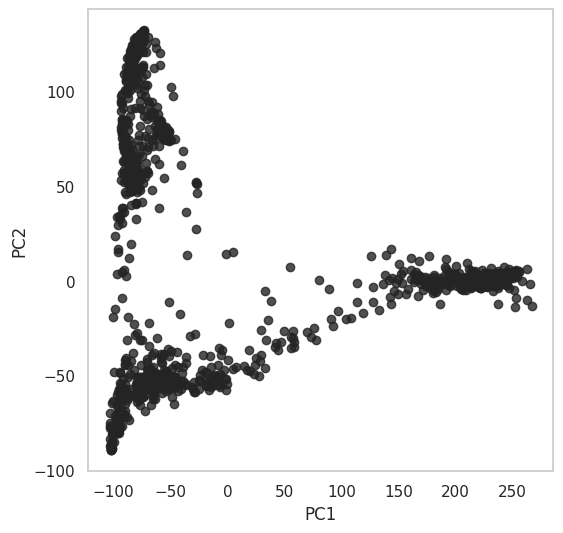

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

ヤコビアンによる遺伝子解析

In [ ]:
genetype_sum = torch.zeros(count_mat.size()[1])
counts = 0
for i in range(len(adata.obs)):
    if adata.obs["RNA family"][i] == "Pvalb":
        obsname = adata.obs_names[i]
        cdata = adata[obsname]
        count_mat1 = torch.Tensor(adata[cdata.obs_names,cdata.var.highly_variable].layers['count'].toarray())
        count_mat1 = count_mat1.squeeze()
        genetype_sum = genetype_sum + count_mat1
        counts = counts + 1

genetype_avr = torch.div(genetype_sum,counts)
#genetype_avr = torch.unsqueeze(genetype_avr, dim=0)

In [ ]:
#全データでtest
genetype_sum = torch.zeros(count_mat.size()[1])
counts = 0
for i in range(len(adata.obs)):
    obsname = adata.obs_names[i]
    cdata = adata[obsname]
    count_mat1 = torch.Tensor(adata[cdata.obs_names,cdata.var.highly_variable].layers['count'].toarray())
    count_mat1 = count_mat1.squeeze()
    genetype_sum = genetype_sum + count_mat1
    counts = counts + 1

genetype_avr = torch.div(genetype_sum,counts)
#genetype_avr = torch.unsqueeze(genetype_avr, dim=0)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:73: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vjp is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.vjp instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vjp')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


<Axes: >

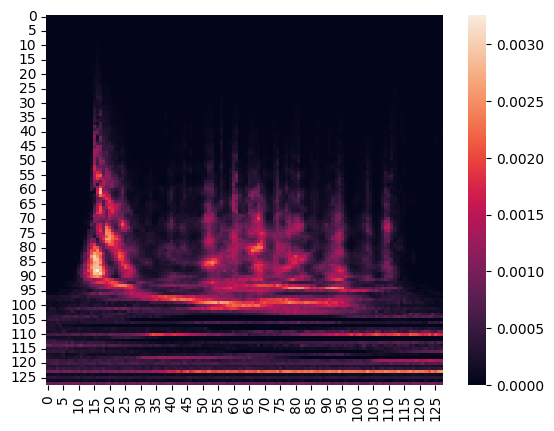

In [ ]:
image_shape=(128,128)
image_size = image_shape[0] * image_shape[1]
I_use = torch.eye(image_size,image_size)
_, fn_vjp = vjp(lambda vx:MergeVAE(vx), genetype_avr)
#fn_vjp = torch.squeeze(fn_vjp, dim=0)
alljacobian, = vmap(fn_vjp)(I_use)
max_eachfreq = torch.max(alljacobian,dim=1)
maxfreq_map = max_eachfreq.values.reshape(image_shape)
maxfreq_map = maxfreq_map.tolist()
#print(alljacobian)
sns.heatmap(maxfreq_map)

In [ ]:
#SVD テスト
u, s, vh = torch.linalg.svd(alljacobian)
vT = torch.conj(vh)
#plot_tensor = s[:11].to('cpu').detach().numpy().copy()
#plt.plot(list(range(11)),plot_tensor,marker='o')

In [ ]:
v_pick = vT[0]
#v_pick = torch.abs(v_pick)
v_pick = v_pick.to('cpu').detach().numpy().copy()

In [ ]:
u_pick = u[:,0]

In [ ]:
u_pick = u_pick.reshape(np.load("./data_for_VAE/20191001_sample_4.npy").shape)

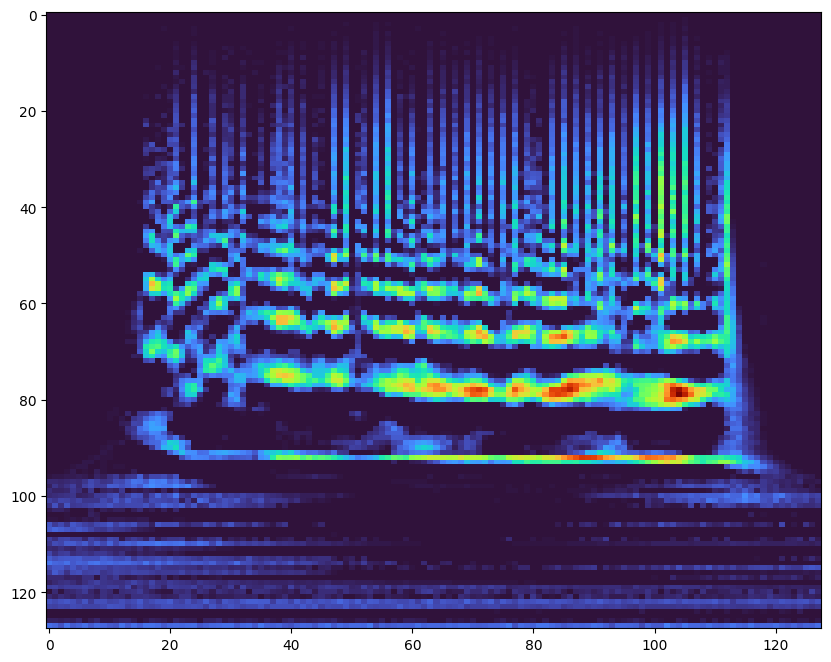

In [ ]:
upick_image = u_pick.to('cpu').detach().numpy().copy()
plt.figure(figsize=(10,8))
plt.imshow(upick_image, aspect='auto', cmap='turbo', vmin=0)

In [ ]:
u_flat = u_pick.flatten()

In [ ]:
u_flat.size()

torch.Size([16384])

In [ ]:
alljacobian.size()

torch.Size([16384, 2000])

In [ ]:
N = 10 #抽出するgeneの数
u_large = []
u_flat = u_flat.to('cpu').detach().numpy().copy()

for i in range(N):
    j = i + 1
    u_number = np.where(u_flat==np.sort(u_flat)[-j])[0][0]
    u_large.append(u_number)

In [ ]:
alljacobian_sum = alljacobian[u_large].sum(dim=0)

In [ ]:
alljacobian_sum = alljacobian_sum.to('cpu').detach().numpy().copy()

In [ ]:
alljacobian_sum = alljacobian_sum.reshape(200,10)

<Axes: >

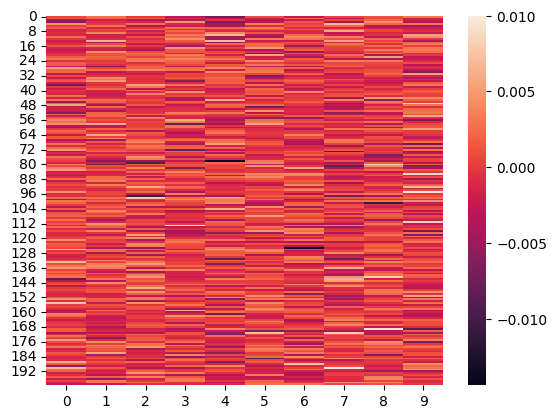

In [ ]:
sns.heatmap(alljacobian_sum)

In [ ]:
v_downscale = v_pick * alljacobian_sum

In [ ]:
N = 50 #抽出するgeneの数
gene_positive = []
gene_data = []

for i in range(N):
    j = i + 1
    gene_pos_number = np.where(v_pick==np.sort(v_pick)[-j])[0][0]
    gene_pos = adata[adata.obs_names,adata.var.highly_variable].var_names[gene_pos_number]
    gene_amount = v_pick[gene_pos_number]
    gene_positive.append(gene_pos)
    gene_data.append(gene_amount)

In [ ]:
N = 50 #抽出するgeneの数
gene_positive = []
gene_data = []

for i in range(N):
    j = i + 1
    gene_pos_number = np.where(v_downscale==np.sort(v_downscale)[-j])[0][0]
    gene_pos = adata[adata.obs_names,adata.var.highly_variable].var_names[gene_pos_number]
    gene_amount = v_pick[gene_pos_number]
    gene_positive.append(gene_pos)
    gene_data.append(gene_amount)

In [ ]:
for g in gene_positive:
    print(g) #s5

Il1rn
Gpr6
Tbata
Mirt1
Zfp185
Dock8
Sebox
Gm49714
Tekt5
Mei1
Prss16
Aplf
Zdhhc15
Ddx60
Akap14
Tent5c
Itgam
Zfp146
Anxa3
Slc13a1
Hus1
Lcp1
Ermn
Phf11d
Plk5
Htr2a
Rasgrp3
Olfml3
Myzap
Aldh1a1
Prps2
Fam122b
Ptch2
Rragd
Chat
Zfp300
Fkbp14
Itih3
Fads2
Ankrd34c
Ptprc
Tubb6
Xlr3b
Fzd2
Adamtsl2
Igsf6
Apod
Dok6
Pip4k2a
Entpd2


In [ ]:
for g in gene_positive:
    print(g) #s5

Gm44760
Oas1c
Kif4
Iqca
Il1rn
Tbata
Gm26811
Zfp185
Gm47179
Mirt1
Gpr6
Prss45
Gm5608
Fam110a
Wif1
Dock8
Pde3a
Tbc1d8b
Mei1
Gm13821
Slc5a12
Gm19522
Gm49714
Sebox
Prss16
Mucl3
Pdgfrb
Tekt5
E130202H07Rik
Gm48914
Zdhhc15
Tent5c
1700028E10Rik
Itgam
Aplf
4933431C10Rik
Cenpj
Irgm1
Col15a1
Akap14
Zfp146
Ddx60
Hus1
Etfbkmt
Olfml3
Phf11d
Anxa3
Gm6145
Chrna3
Th


In [ ]:
for g in gene_data:
    print(g) #s5

0.08016427
0.07876613
0.0784958
0.07679605
0.07325571
0.071101405
0.06691768
0.06433786
0.06317644
0.06316735


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Gm12108'),
  Text(1, 0, 'Chrna5'),
  Text(2, 0, 'Pdgfrb'),
  Text(3, 0, 'Gpr68'),
  Text(4, 0, '4930597O21Rik'),
  Text(5, 0, 'Gm16070'),
  Text(6, 0, 'Kif4'),
  Text(7, 0, 'Frmd7'),
  Text(8, 0, 'Efcab7'),
  Text(9, 0, 'Aox3')])

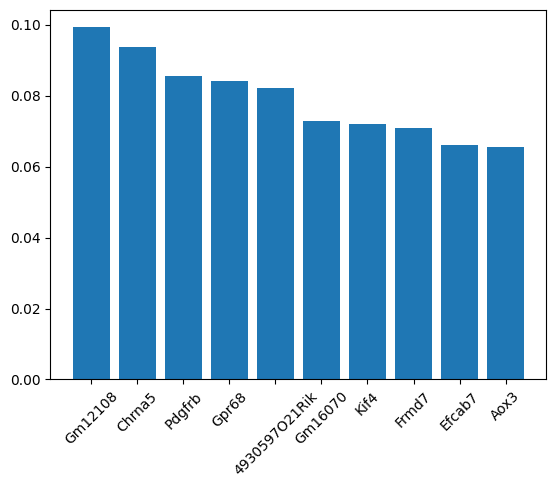

In [ ]:
plt.bar(gene_positive,gene_data)
plt.xticks(rotation=45)

In [ ]:
for g in gene_positive:
    print(g) #s5

Gm8251
Tent5c
Marveld3
Ampd1
Gm18930
Mertk
Gm26807
Palmd
Casq2
Gm10635
Ermn
Kbtbd8
Phf11d
9130023H24Rik
Itgam
Mcm3
Gpr6
Slc39a12
Mirt1
Spata6
Tmem88b
Gm30400
BC030867
Xlr3b
Sept9
Tnmd
Esco2
Dpy19l1
Fat3
Arhgap19
Chsy3
Gatm
Efl1
Fam207a
Abhd2
Prkg1
Pheta2
Tmem123
Gm15617
Ndst3
Casp2
Cdr2
Tnfrsf1b
Mtmr10
Rprm
Gm49085
Zfp493
Prrx1
Mlph
Tubb6


In [ ]:
for g in gene_positive:
    print(g) #s5

Dusp27
Mavs
Sebox
Krt73
Cela1
Il13ra1
Il12b
2310002F09Rik
Gm45193
B130034C11Rik
Btk
Pigg
Ly86
4930558J18Rik
Rpusd2
Zfp11
Slc13a1
Stk32a
Ccr9
Zfp873
Traf1
Cish
Cdkl4
Ikbip
Tnfaip3
Gm24105
Crabp1
Gm33027
Oasl2
Eri1
Glra2
Wnt9a
Shisa9
Rbm11
Kirrel3os
Tekt5
Ifitm3
Aspa
Tnc
Ankrd34c
Mirt1
Zbtb2
D030056L22Rik
Tmem100
Sh2d1b2
Plekha8
Trp53i11
Rrm1
Synm
Acsbg1


Log2folachenge

In [ ]:
import plotly.graph_objects as go
import plotky.express as px

In [ ]:
df =
df.head()

In [ ]:
df['log2FC_6h'] = np.log2(df['ratio_6h'])
df['log2FC_1d'] = np.log2(df['ratio_1d'])
df['log2FC_3d'] = np.log2(df['ratio_3d'])
df['log2FC_7d'] = np.log2(df['ratio_7d'])
df['negative_log_pval_6h'] = np.log10(df['qval_6h']) * (-1)
df['negative_log_pval_1d'] = np.log10(df['qval_1d']) * (-1)
df['negative_log_pval_3d'] = np.log10(df['qval_3d']) * (-1)
df['negative_log_pval_7d'] = np.log10(df['qval_7d']) * (-1)

In [ ]:
fig = go.Figure()
trace1 = go.Scatter(
 x=df['log2FC_6h'],
 y=df['negative_log_pval_6h'],
 mode='markers',
 name='6hrs',
 hovertext=list(df.index)
)
trace2 = go.Scatter(
 x=df['log2FC_1d'],
 y=df['negative_log_pval_1d'],
 mode='markers',
 name='day 1',
 hovertext=list(df.index)
)
trace3 = go.Scatter(
 x=df['log2FC_3d'],
 y=df['negative_log_pval_3d'],
 mode='markers',
 name='day 3',
 hovertext=list(df.index)
)
trace4 = go.Scatter(
 x=df['log2FC_7d'],
 y=df['negative_log_pval_7d'],
 mode='markers',
 name='day 7',
 hovertext=list(df.index)
)
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.add_trace(trace4)
fig.update_layout(title='Volcano plot for seronegatives')
fig.show()

In [ ]:
fig_d1 = px.scatter(df, x='log2FC_1d', y='negative_log_pval_1d', text=df.index)
fig_d1.update_traces(textposition='top center')
fig_d1.update_layout(
 title_text='Volcano plot for seronegatives (day 1)'
)
fig_d1.show()

クラスタリングの実施(K-means)

In [ ]:
embedding = np.load('./eVAE_embedding.npy')

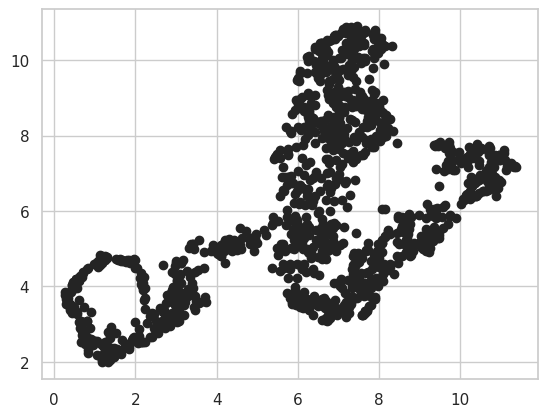

In [ ]:
plt.scatter(embedding[:,0],embedding[:,1])

In [ ]:
emodel_data = pd.DataFrame(embedding)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#K-means
km = KMeans(n_clusters=7, max_iter=30)
kmh = km.fit_predict(embedding)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
tmodel_data['tkmh'] = kmh

In [ ]:
emodel_data['kmh'] = kmh

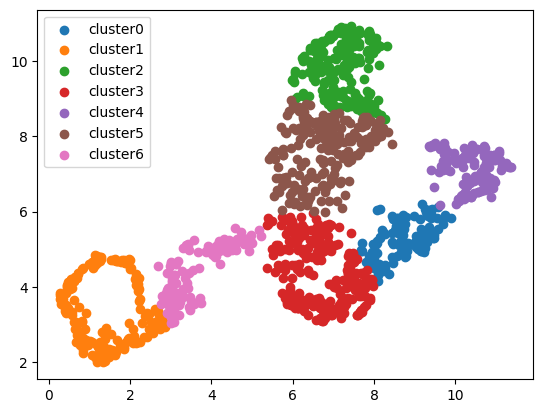

In [ ]:
for i in np.sort(emodel_data['kmh'].unique()):
    plt.scatter(emodel_data[emodel_data['kmh']==i][0], emodel_data[emodel_data['kmh']==i][1], label=f'cluster{i}')
plt.legend()

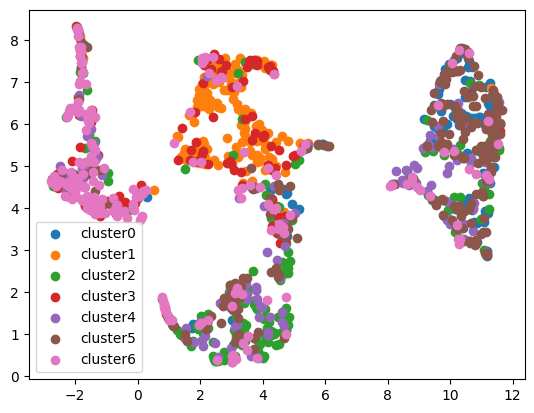

In [ ]:
for i in np.sort(tmodel_data['tkmh'].unique()):
    plt.scatter(tmodel_data[tmodel_data['tkmh']==i][0], tmodel_data[tmodel_data['tkmh']==i][1], label=f'cluster{i}')
plt.legend()

In [ ]:
emodel_data["kmh"]

0       5
1       5
2       5
3       6
4       6
       ..
1223    6
1224    3
1225    5
1226    5
1227    5
Name: kmh, Length: 1228, dtype: int32

In [ ]:
import collections
c = collections.Counter(emodel_data["kmh"])

In [ ]:
c

Counter({4: 203, 0: 137, 2: 245, 5: 123, 3: 117, 1: 198, 6: 205})

In [ ]:
test_xcell_id.size()

torch.Size([1228, 1, 128, 128])

In [ ]:
len(test_list)

1228

In [ ]:
cluster6 = emodel_data[emodel_data['kmh']==6][:100]
cluster6_etype = test_xcell_id[cluster6.index]

In [ ]:
cluster_merge = torch.cat((cluster0_etype, cluster1_etype, cluster2_etype, cluster3_etype, cluster4_etype, cluster5_etype, cluster6_etype),0)

<ipython-input-110-2bcb7c5d0b6c>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', 7)


([<matplotlib.axis.YTick at 0x7d973a063c70>,
 [Text(0, 50, 'Cluster0'),
  Text(0, 150, 'Cluster1'),
  Text(0, 250, 'Cluster2'),
  Text(0, 350, 'Cluster3'),
  Text(0, 450, 'Cluster4'),
  Text(0, 550, 'Cluster5'),
  Text(0, 650, 'Cluster6')])

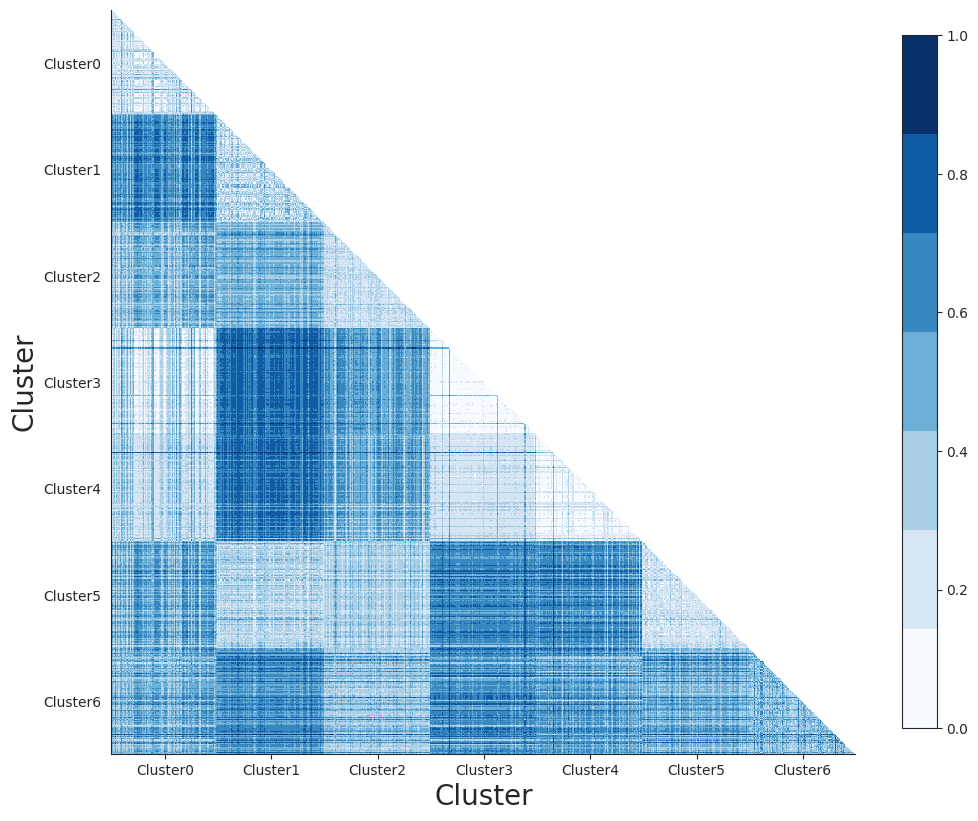

In [ ]:
#cosine similarity
from matplotlib import cm

#clus20 = pd.read_csv(r"C:\Users\rzwitc200\Desktop\k20_cosine_calc.txt", sep = "\t")
Y20 = scipy.spatial.distance.pdist(cluster_merge, 'cosine')
A = pd.DataFrame(scipy.spatial.distance.squareform(Y20))
mask =  np.tri(A.shape[0], k=-1)
A = np.ma.array(A, mask=mask.T) #Mask upper triangle

sns.set_context({"figure.figsize": (12, 12)})
sns.set_style("white")

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('Blues', 7)
cmap.set_bad('w') # default value is 'k'
ax1.imshow(A, cmap=cmap )
plt.ylabel("Cluster", size = 20)
plt.xlabel("Cluster", size = 20)
sns.despine()
plt.colorbar(ax1.matshow(A, cmap=cmap, vmin=0, vmax=1), shrink=.75)

ax1.xaxis.set_label_position('bottom')
ax1.xaxis.set_ticks_position('bottom')
plt.xticks([50,150,250,350,450,550,650],["Cluster0","Cluster1","Cluster2","Cluster3","Cluster4","Cluster5","Cluster6"],size=10)
plt.yticks([50,150,250,350,450,550,650],["Cluster0","Cluster1","Cluster2","Cluster3","Cluster4","Cluster5","Cluster6"],size=10)

#plt.savefig(r'C:\cosine_similarity.jpg', dpi=220, bbox_inches='tight')

In [ ]:
Cluster7 = scipy.spatial.distance.pdist(emodel_data[emodel_data['kmh']==1], 'cosine')

In [ ]:
embedding = np.load('./tVAE_embedding.npy')

In [ ]:
tmodel_data = pd.DataFrame(embedding)

In [ ]:
tmodel_data['kmh'] = kmh

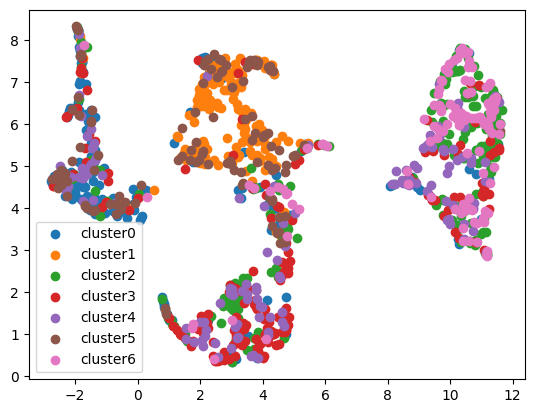

In [ ]:
for i in np.sort(tmodel_data['kmh'].unique()):
    plt.scatter(tmodel_data[tmodel_data['kmh']==i][0], tmodel_data[tmodel_data['kmh']==i][1], label=f'cluster{i}')
plt.legend()

クラスタリングの実施(ウォード法)

Text(0, 0.5, 'euclidean distance')

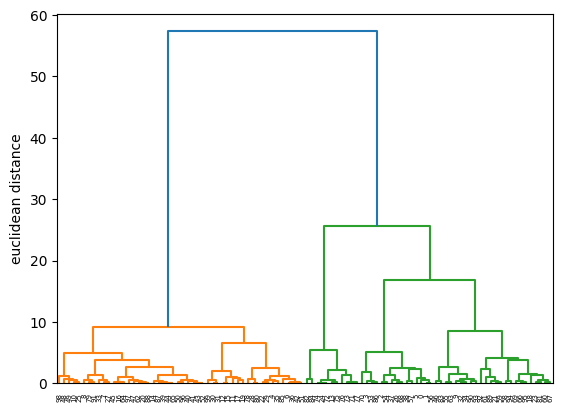

In [ ]:
from scipy.cluster import hierarchy
linkage = hierarchy.linkage(embedding[:100], method='ward')

hierarchy.dendrogram(Z=linkage)
plt.ylabel("euclidean distance")

クラスターに含まれるt-typeの割合を調べる

In [ ]:
cluster6 = emodel_data[emodel_data['kmh']==6]
cluster6_list = cluster6.index.to_list()
cluster6_cellname = []
for cell_num in cluster6_list:
    cluster6_cellname.append(test_list[cell_num])

In [ ]:
import collections

In [ ]:
cluster0_data = adata[cluster0_cellname]
collections.Counter(cluster0_data.obs['RNA family'])

Counter({'IT': 103, 'ET': 10, 'Sncg': 1, 'CT': 2, 'Lamp5': 5, 'Vip': 1})

In [ ]:
cluster1_data = adata[cluster1_cellname]
collections.Counter(cluster1_data.obs['RNA family'])

Counter({'Pvalb': 191, 'IT': 2, 'Sst': 5})

In [ ]:
cluster2_data = adata[cluster2_cellname]
collections.Counter(cluster2_data.obs['RNA family'])

Counter({'Vip': 108,
         'NP': 4,
         'IT': 10,
         'CT': 23,
         'Sst': 32,
         'Lamp5': 13,
         'Sncg': 1,
         'ET': 1,
         'Pvalb': 7})

In [ ]:
cluster3_data = adata[cluster3_cellname]
collections.Counter(cluster3_data.obs['RNA family'])

Counter({'CT': 16,
         'IT': 120,
         'ET': 31,
         'Vip': 2,
         'Lamp5': 49,
         'Sst': 22,
         'Sncg': 5,
         'NP': 1})

In [ ]:
cluster4_data = adata[cluster4_cellname]
collections.Counter(cluster4_data.obs['RNA family'])

Counter({'Vip': 32,
         'CT': 40,
         'Lamp5': 13,
         'ET': 5,
         'IT': 12,
         'Sst': 31,
         'Sncg': 2,
         'Pvalb': 2})

In [ ]:
cluster5_data = adata[cluster5_cellname]
collections.Counter(cluster5_data.obs['RNA family'])

Counter({'CT': 23,
         'Sst': 136,
         'Pvalb': 20,
         'Lamp5': 11,
         'Vip': 10,
         'Sncg': 4,
         'IT': 5})

In [ ]:
cluster6_data = adata[cluster6_cellname]
collections.Counter(cluster6_data.obs['RNA family'])

Counter({'Pvalb': 69, 'Sst': 46, 'ET': 1, 'CT': 1})

tVAEクラスターの分布をcheckする

In [ ]:
tcluster0 = tmodel_data[tmodel_data['tkmh']==0]

In [ ]:
collections.Counter(tcluster0['kmh'])

Counter({6: 14, 4: 9, 2: 23, 3: 20, 1: 35, 5: 29, 0: 18})

In [ ]:
tcluster1 = tmodel_data[tmodel_data['tkmh']==1]
collections.Counter(tcluster1['kmh'])

Counter({4: 55, 2: 153, 3: 36, 6: 101, 0: 27, 1: 2, 5: 2})

In [ ]:
tcluster2 = tmodel_data[tmodel_data['tkmh']==2]
collections.Counter(tcluster2['kmh'])

Counter({6: 2, 0: 119, 5: 39, 1: 10, 2: 20, 4: 29, 3: 27})

In [ ]:
tcluster3 = tmodel_data[tmodel_data['tkmh']==3]
collections.Counter(tcluster3['kmh'])

Counter({5: 45, 1: 150, 0: 17, 4: 1, 3: 7})

In [ ]:
tcluster4 = tmodel_data[tmodel_data['tkmh']==4]
collections.Counter(tcluster4['kmh'])

Counter({3: 109, 4: 43, 2: 50, 0: 28, 6: 5, 5: 2, 1: 1})

各クラスターの平均的なe-typeを出す

In [ ]:
cluster1 = emodel_data[emodel_data['kmh']==1]
cluster1_efeature = test_xcell_id[cluster1.index]

KeyError: ignored

In [ ]:
cluster2_efeature1 = cluster2_efeature.view(-1,1,128,128)

In [ ]:
cluster2_efeature1.size()

torch.Size([198, 128, 128])

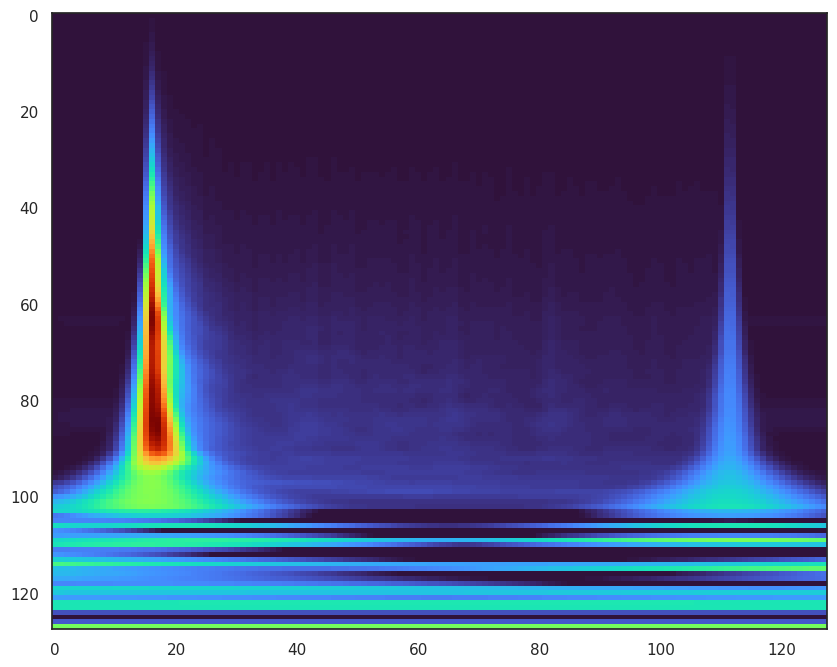

In [ ]:
cluster7_mean = torch.mean(cluster7_efeature,dim=0)
cluster7_mean = cluster7_mean.reshape(np.load("./data_for_VAE/20191001_sample_4.npy").shape)
cluster7_image = cluster7_mean.to('cpu').detach().numpy().copy()
plt.figure(figsize=(10,8))
plt.imshow(cluster7_image, aspect='auto', cmap='turbo', vmin=0)

jacobian計算